# **1.Import Library**

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split 
import shutil
import random

# **2. Load Dataset Dan Melihat Struktur Dataset**

In [8]:
dataset_dir = "dataset_sampah"

if not os.path.exists(dataset_dir):
    print(f"ERROR: Direktori dataset '{dataset_dir}' tidak ditemukan. Pastikan dataset_sampah sudah ada.")
    exit()

classes = os.listdir(dataset_dir)
classes = [cls for cls in classes if os.path.isdir(os.path.join(dataset_dir, cls))] 

print("Jumlah kelas:", len(classes))
print("Daftar kelas:", classes)

for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    n_image = len([name for name in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, name))])
    print(f"Jumlah gambar kelas {cls}: {n_image}")


Jumlah kelas: 6
Daftar kelas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Jumlah gambar kelas cardboard: 403
Jumlah gambar kelas glass: 501
Jumlah gambar kelas metal: 410
Jumlah gambar kelas paper: 594
Jumlah gambar kelas plastic: 482
Jumlah gambar kelas trash: 137


# **3. Split Dataset**

In [9]:
def split_dataset(src_dir, dest_dir, train_ratio=0.7, val_ratio=0.15):
    if os.path.exists(dest_dir):
        shutil.rmtree(dest_dir)
    os.makedirs(dest_dir)

    classes = os.listdir(src_dir)
    classes = [cls for cls in classes if os.path.isdir(os.path.join(src_dir, cls))]

    for cls in classes:
        src_path = os.path.join(src_dir, cls)
        images = [name for name in os.listdir(src_path) if os.path.isfile(os.path.join(src_path, name))] 
        random.shuffle(images)

        total = len(images)
        train_end = int(train_ratio * total)
        val_end = int((train_ratio + val_ratio) * total)

        splits = {
            "train": images[:train_end],
            "val": images[train_end:val_end],
            "test": images[val_end:]
        }

        for split_name, file_list in splits.items():
            dest_path = os.path.join(dest_dir, split_name, cls)
            os.makedirs(dest_path, exist_ok=True)
            for img_file in file_list:
                src_file = os.path.join(src_path, img_file)
                dst_file = os.path.join(dest_path, img_file)
                try:
                    shutil.copy2(src_file, dst_file)
                except FileNotFoundError:
                    print(f"Warning: File not found {src_file}. Skipping.")

    print("Dataset berhasil dibagi!")

split_dataset("dataset_sampah", "dataset_split")

Dataset berhasil dibagi!


# **4. Data Augmentasi**

In [10]:
img_height = 150
img_width = 150
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    shear_range=0.2,
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "dataset_split/train",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    "dataset_split/val",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    "dataset_split/test",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False 
)


Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


# **5. Membuat Model CNN**

In [16]:
num_classes = train_generator.num_classes
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

c:\Users\fayiz_lgdvoec\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **6.Compile dan Training Model CNN**

In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

os.makedirs("checkpoints", exist_ok=True)

checkpoint_path = "checkpoints/best_model.weights.h5"

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=35,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_best_only=True,
        save_weights_only=True,
        verbose=1  
    )
]

history = model.fit(
    train_generator,
    epochs=150,
    validation_data=val_generator,
    callbacks=callbacks
)

print(" Model selesai dilatih dan disimpan di:", checkpoint_path)


c:\Users\fayiz_lgdvoec\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.2619 - loss: 1.7432
Epoch 1: val_loss improved from inf to 1.48549, saving model to checkpoints/best_model.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 38s 635ms/step - accuracy: 0.2632 - loss: 1.7403 - val_accuracy: 0.3783 - val_loss: 1.4855
Epoch 2/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.4245 - loss: 1.3836
Epoch 2: val_loss improved from 1.48549 to 1.41240, saving model to checkpoints/best_model.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 22s 393ms/step - accuracy: 0.4248 - loss: 1.3834 - val_accuracy: 0.3968 - val_loss: 1.4124
Epoch 3/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.4403 - loss: 1.3622
Epoch 3: val_loss improved from 1.41240 to 1.33781, saving model to checkpoints/best_model.weights.h5
56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 405ms/step - accuracy: 0.4406 - loss: 1.3619 - val_accuracy: 0.4339 - val_loss: 1.3378
Epoch 4/150
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.4799 - loss: 1.2

# **7.Menampilkan Plot Akurasi Model**

 Akurasi Akhir (Train): 96.49%
 Akurasi Akhir (Val): 80.69%
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8302 - loss: 0.5551
 Akurasi Model Terbaik pada Validasi: 85.71%

--- Evaluasi Model pada Test Set ---
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 419ms/step - accuracy: 0.8687 - loss: 0.3638
 Akurasi pada test set: 87.73%


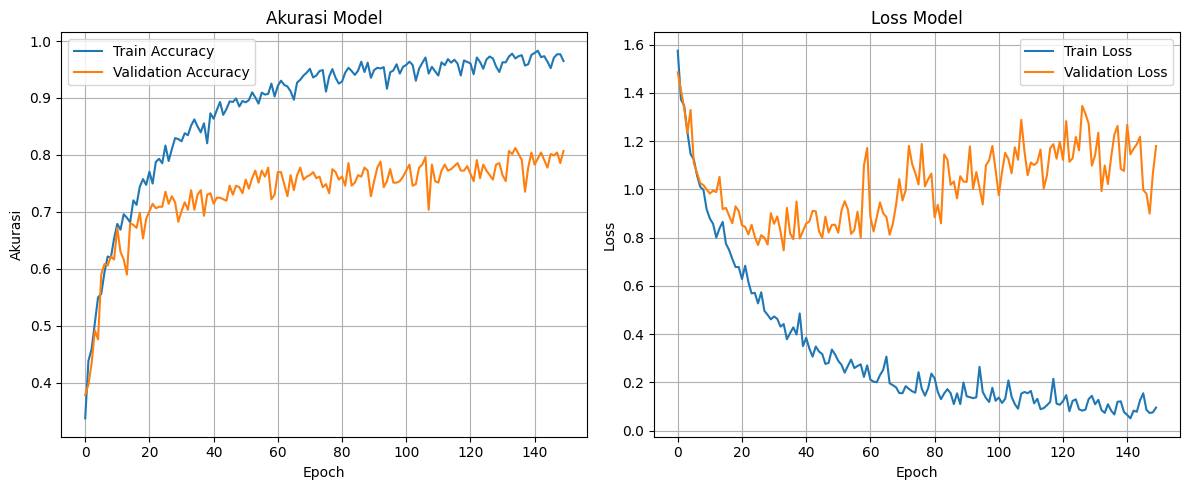

In [13]:
model.load_weights("best_model.weights.h5")

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f" Akurasi Akhir (Train): {final_train_acc:.2%}")
print(f" Akurasi Akhir (Val): {final_val_acc:.2%}")

loss_val_best, accuracy_val_best = model.evaluate(val_generator)
print(f" Akurasi Model Terbaik pada Validasi: {accuracy_val_best:.2%}")

print("\n--- Evaluasi Model pada Test Set ---")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f" Akurasi pada test set: {test_accuracy * 100:.2f}%")

# Plot Akurasi dan Loss
plt.figure(figsize=(12, 5))

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **8. Simpan Ke SavedModel,TFJS, TFLite**

In [27]:

# Simpan model dalam format SavedModel
saved_model_dir = "saved_model"
model.export(saved_model_dir)
print(f"Model disimpan dalam format SavedModel di folder: {saved_model_dir}")

# Simpan model dalam format TensorFlow Lite
tflite_model_path = "tflite_model/model.tflite"
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

tflite_model = converter.convert()
os.makedirs("tflite_model", exist_ok=True)
with open(tflite_model_path, "wb") as f:
    f.write(tflite_model)

if os.path.exists("labels.txt"):
    shutil.copy("labels.txt", "tflite_model/labels.txt")

print("Model TFLite berhasil disimpan di folder: tflite_model")

# Petunjuk untuk konversi ke TensorFlow.js
print("\n📢 Untuk mengonversi ke TensorFlow.js, jalankan perintah berikut di CMD:")
print("tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model saved_model tfjs_model")


INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor_10')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2526054709200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526054709392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526054709968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526054710736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526054710928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526054710160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526054708816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526055646224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526055646416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2526055646992: TensorSpec(shape=(), dtype=tf.resource, name=None)
Model disimpan dalam format SavedModel